This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

### This is using compensated images
- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
import sys

In [2]:
sys.executable

'/home/cjw/anaconda3/envs/deep/bin/python'

In [3]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import hdbscan

from autoencoder import network
from autoencoder import utils

%matplotlib inline
%pwd

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'/media/cjw/PythonLib/cjwdeeplearning/autoencoder/Snail'

In [4]:
tf.__version__

'1.8.0'

In [5]:
datadir =  "/media/cjw/Data/cyto/Snail/mmCompensated/"
cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-07-13-Snail/checkpoint-2018-07-13-16-21-52/"
aemeta = 'autoencoder-256x-88980.meta'
if os.path.exists(cp_dir + aemeta):
    print("OK")

OK


In [6]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
print(cp_dir)

if os.path.exists(cp_dir):
    print("OK, exists")
else:
    print("Oh no")
#checkpoint-2018-03-02-16-31-42/'
p_width = 32
p_height = 32
p_nchannels = 4
p_channels = [0,1,3,4]
p_nepochs = 60
p_batchsize = 128
p_learning_rate = 0.0001  #.00005
p_restore = False
p_latent_size = 256 #128 + 64
p_droprate = 0.85
p_stdev = .04
p_slam = .001
p_denoise = None
enc_sizes = [(128, 3), (256, 3), (512, 3)]  #128, 3)]

dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network.ae_loss(images, sdd)

opt = network.model_opt(loss, p_learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


/media/cjw/Data/cyto/Checkpoints/2018-07-13-Snail/checkpoint-2018-07-13-16-21-52/
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
isize:  4 32
dh0 (?, 32, 32, 4)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-07-13-Snail/checkpoint-2018-07-13-16-21-52/autoencoder-256x-88980


In [7]:
#datadir = "/media/cjw/Data/cyto/mmFromTifs/"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    #print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/media/cjw/Data/cyto/Snail/mmCompensated/snail4_ice.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail1_phago.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail5_no_bact.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail3_phago.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail1_edta.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail1_no_bact.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail2_edta.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail5_ice.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail3_no_bact.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail5_edta.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail5_phago.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail4_no_bact.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail2_ice.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail3_ice.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail3_edta.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/snail4_edta.mm', '/media/cjw/Data/cyto/Snail/mmCompensated/sn

dict_keys(['snail4_ice.mm', 'snail1_phago.mm', 'snail5_no_bact.mm', 'snail3_phago.mm', 'snail1_edta.mm', 'snail1_no_bact.mm', 'snail2_edta.mm', 'snail5_ice.mm', 'snail3_no_bact.mm', 'snail5_edta.mm', 'snail5_phago.mm', 'snail4_no_bact.mm', 'snail2_ice.mm', 'snail3_ice.mm', 'snail3_edta.mm', 'snail4_edta.mm', 'snail2_phago.mm', 'snail4_phago.mm', 'snail1_ice.mm', 'snail2_no_bact.mm'])

In [23]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    #print(n)
    file = n*[key[0:-3].lower()]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_no_bact'in file.lower():
        treatment = 'no_bact'
    elif '_phago'in file.lower():
        treatment = 'phago'
    elif '_edta'in file.lower():
        treatment = 'edta'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:7])

alldf['treatment'] = trts
alldf['run'] = runs


In [10]:
cmapdf = pd.read_pickle('/media/cjw/Data/cyto/map.pickle')
alldf = alldf.merge(cmapdf, on=['file', 'fid'])
alldf = alldf[alldf['cid'] != -1]

clustermap = pd.read_pickle('/media/cjw/Data/cyto/cluster_map.pickle')
alldf = alldf.merge(clustermap, on=['file', 'cid'])

myclustermap = pd.read_pickle('/media/cjw/Data/cyto/my_cluster_map.pickle')
alldf = alldf.merge(myclustermap, on=['file', 'fid'])
print(len(alldf))

169599


In [24]:

df = alldf.sample(frac=.03)
df = df.reset_index()
print(len(df))
df.tail()

5701


,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run
5696,108653,0,3986,0,snail4_no_bact,108653,snail4_no_bact.mm,0,0,0,32,32,no_bact,snail4_
5697,170206,0,9278,0,snail4_phago,170206,snail4_phago.mm,0,0,0,32,32,phago,snail4_
5698,110296,0,5629,0,snail4_no_bact,110296,snail4_no_bact.mm,0,0,0,32,32,no_bact,snail4_
5699,186109,0,5703,0,snail2_no_bact,186109,snail2_no_bact.mm,0,0,0,32,32,no_bact,snail2_
5700,110919,0,6252,0,snail4_no_bact,110919,snail4_no_bact.mm,0,0,0,32,32,no_bact,snail4_


In [14]:
# import pickle
# cmapdf = pd.read_pickle('/media/cjw/Data/cyto/map.pickle')
# cmapdf.tail()

In [15]:
# testdf = alldf.merge(cmapdf, on=['file', 'fid'])
# len(testdf), len(alldf)

In [25]:
sns.set_style("whitegrid", {'axes.grid' : False})
len(df)

5701

In [26]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        


(5701, 256) (5701, 32, 32, 4)
0.06879521906375885 0.9785031676292419


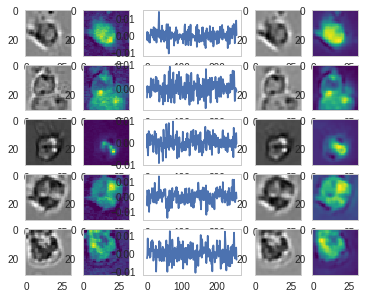

In [27]:
f = plt.figure(figsize=(6, 20))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,6,i*6 + 1)
    plt.imshow(vv[ix,:,:,0], cmap='gray')
    plt.subplot(20,6,i*6 + 2)
    plt.imshow(vv[ix,:,:,1], cmap='viridis')
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,6,i*6 + 5)
    plt.imshow(xdd[ix,:,:,0], cmap='gray')
    plt.subplot(20,6,i*6 + 6)
    plt.imshow(xdd[ix,:,:,1], cmap='viridis')
   

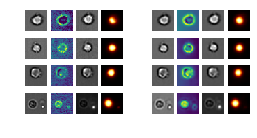

In [28]:
def one_imshow(image, r, c, ic, cmap):
    plt.subplot(16, 9, ic)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

ic = 1

nrows = 4
plt.figure(figsize=(nrows,2*nrows))

for i in range(nrows):
    ix = np.random.randint(0, len(vv))
    one_imshow(vv[ix,:,:,0], nrows, 9, ic, 'gray')
    ic += 1
    
    one_imshow(vv[ix,:,:,1], nrows, 9, ic, 'viridis')
    ic += 1
    
    one_imshow(vv[ix,:,:,2], nrows, 9, ic, 'gray')
    ic += 1
    
    one_imshow(vv[ix,:,:,3], nrows, 9, ic, 'afmhot')
    ic += 1
    ic += 1
    
    one_imshow(xdd[ix,:,:,0], nrows, 9, ic, 'gray')
    ic += 1
    
    one_imshow(xdd[ix,:,:,1], nrows, 9, ic, 'viridis')
    ic += 1
    
    one_imshow(xdd[ix,:,:,2], nrows, 9, ic, 'gray')
    ic += 1
    
    one_imshow(xdd[ix,:,:,3], nrows, 9, ic, 'afmhot')
    ic += 1

#plt.savefig('/media/cjw/Data/cyto/output/decoded.png')

In [29]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
5701
hek (5701, 256)
0 0 (5701, 256) (5701, 256)


(5701, 256)

In [21]:
#from sklearn.preprocessing import normalize
#g_all = normalize(g_all, axis=1)

In [30]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=64, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(5701, 64)
[6.72600686e-05 4.75296343e-05 4.09773246e-05 3.83620038e-05
 3.68975925e-05 3.23100905e-05 2.98957422e-05 2.89901198e-05
 2.72091616e-05 2.62617711e-05 2.46981430e-05 2.42408110e-05
 2.28199484e-05 2.16345592e-05 2.15465789e-05 2.05391539e-05
 1.99316008e-05 1.97192285e-05 1.89162672e-05 1.84021869e-05
 1.82333153e-05 1.74094797e-05 1.73693309e-05 1.70603366e-05
 1.67509732e-05 1.61577764e-05 1.57019028e-05 1.55517033e-05
 1.52913023e-05 1.49840321e-05 1.46806585e-05 1.45705239e-05
 1.43444589e-05 1.39823838e-05 1.37619242e-05 1.36802755e-05
 1.35000267e-05 1.34523782e-05 1.32654248e-05 1.29882210e-05
 1.27936312e-05 1.25925528e-05 1.25596679e-05 1.23227208e-05
 1.20280928e-05 1.19663411e-05 1.17783755e-05 1.16643672e-05
 1.15191838e-05 1.12889724e-05 1.11961035e-05 1.11054438e-05
 1.10312523e-05 1.09786319e-05 1.09303259e-05 1.08877327e-05
 1.06816632e-05 1.06054083e-05 1.05398963e-05 1.04715523e-05
 1.03571935e-05 1.02674561e-05 1.01920902e-05 1.01346134e-05]
(64, 256)


In [173]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 22
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agco = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward")
agc = agco.fit_predict(g_all)
gmm = BayesianGaussianMixture(nclust, covariance_type='full')
gmm.fit(g_all)
gm = gmm.predict(g_all)

In [56]:
order = sorted(df['treatment'].unique())
order

['edta', 'ice', 'no_bact', 'phago']

In [57]:
df['gm'] = gm
df['agc'] = agc
df['km'] = km

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


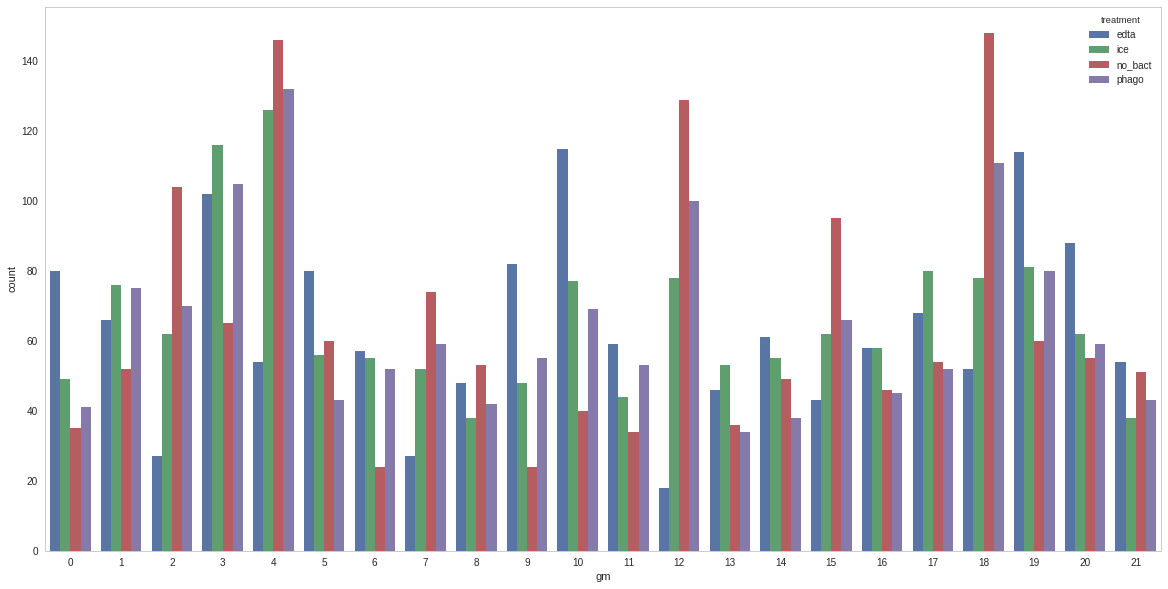

In [174]:

plt.figure(figsize=(20,10))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='gm', data=df, hue='treatment', hue_order=order)

22


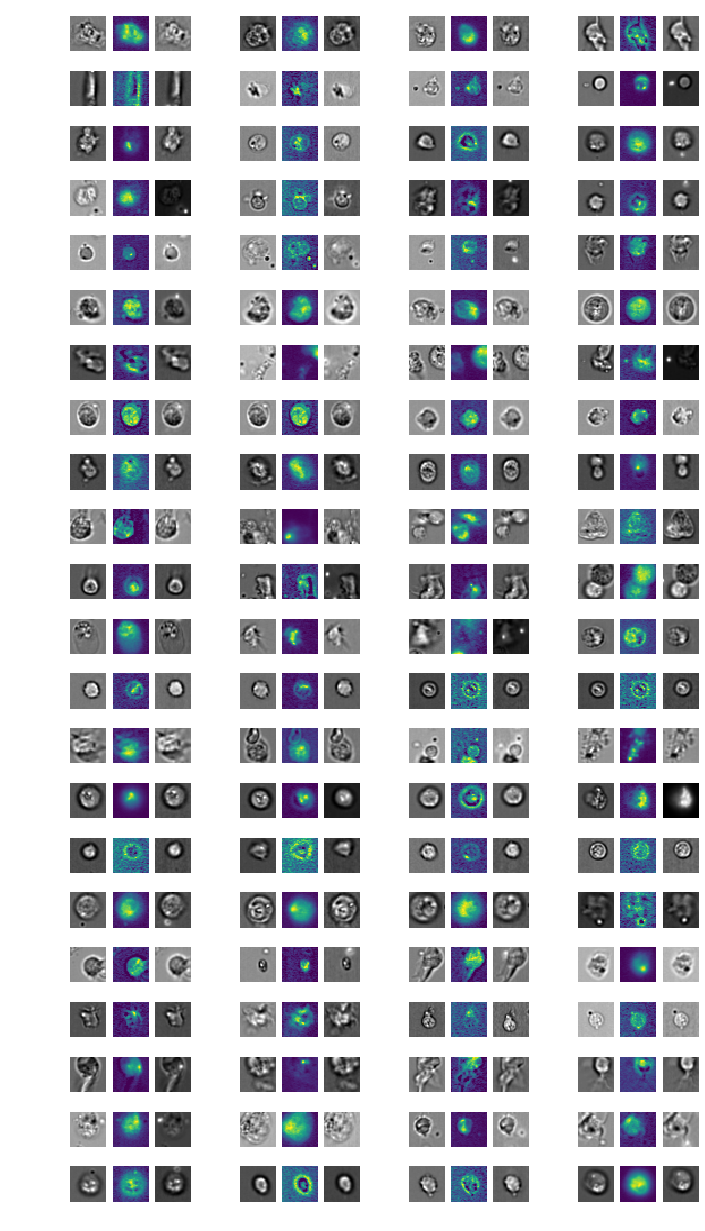

In [59]:
ximages = vv
ucly = sorted(df['gm'].unique())
print(len(ucly))
cly = df['gm'].values
nk = len(ucly) #nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in ucly:
    rowdf = df[df['gm'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[cly == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 16, counter)
    plt.text(0.5,0.5, str(k)[2:], fontsize=12, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 16, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='gray')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(i, counter, k)
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1
        if i < 3:
            counter += 1

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


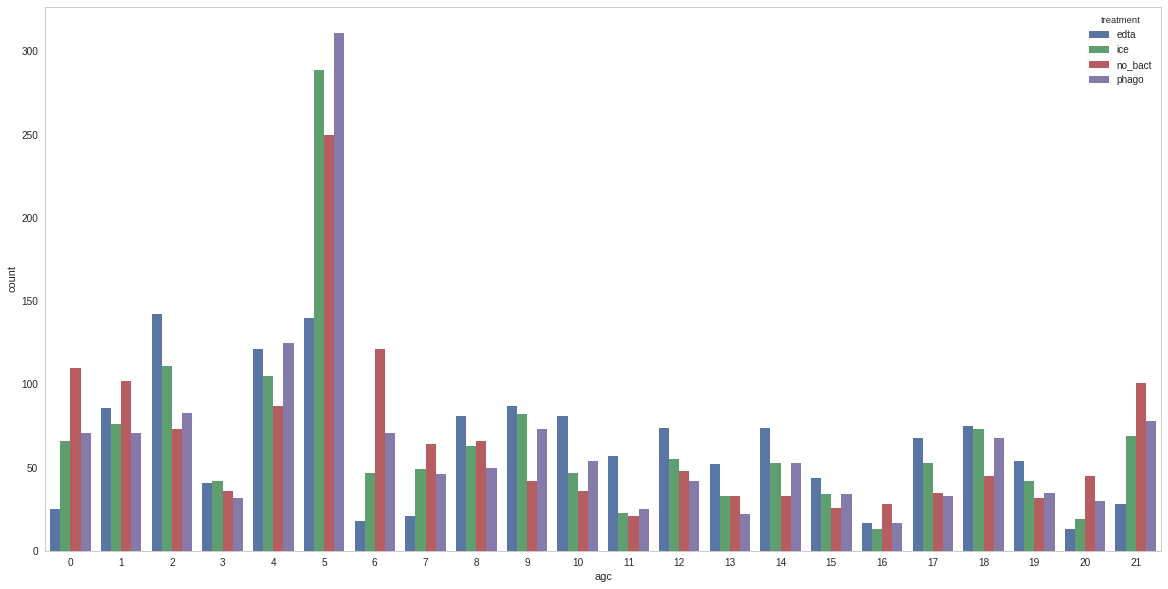

In [60]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='agc', data=df, hue='treatment', hue_order=order)

22


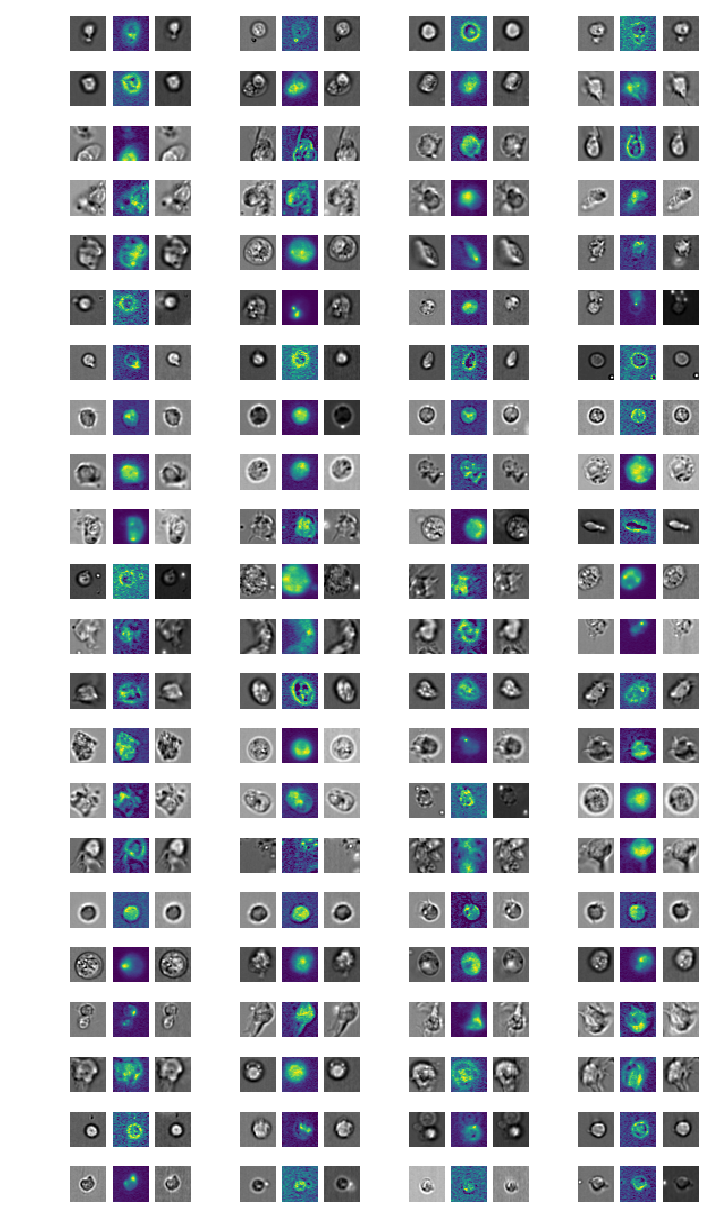

In [61]:
ximages = vv
uclx = sorted(df['agc'].unique())
print(len(uclx))
clx = df['agc'].values
nk = len(uclx) #nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in uclx:
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[clx == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 16, counter)
    plt.text(0.5,0.5, str(k)[2:], fontsize=12, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 16, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 16, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='gray')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(i, counter, k)
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1
        if i < 3:
            counter += 1

In [62]:
len(df[df['file'].str.contains('ccb')])

0

In [63]:
df.head()

,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run,gm,agc,km,tsneX,tsneY
0,110085,0,5418,0,snail4_no_bact,110085,snail4_no_bact.mm,0,0,0,32,32,no_bact,snail4_,12,0,2,-0.713227,-31.618355
1,40186,0,2942,0,snail1_edta,40186,snail1_edta.mm,0,0,0,32,32,edta,snail1_,19,15,19,-15.114527,-17.825232
2,38712,0,1468,0,snail1_edta,38712,snail1_edta.mm,0,0,0,32,32,edta,snail1_,20,14,0,-16.682135,4.894446
3,182340,0,1934,0,snail2_no_bact,182340,snail2_no_bact.mm,0,0,0,32,32,no_bact,snail2_,16,4,15,12.338305,-1.801678
4,6234,0,6234,0,snail4_ice,6234,snail4_ice.mm,0,0,0,32,32,ice,snail4_,17,18,21,7.981800,17.804991


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

-------------------------------------------------------------------------

In [64]:
import matplotlib 
def display_cluster(cluster_num, nrows=16, outfile=None, c=None, df=None):
    
    if outfile:
        plt.ioff()
    tn = cluster_num
    images4 = ximages[c == tn]
    g4 = g_all[c == tn]
    fig = plt.figure(figsize=(.5*16,.5*1.6*1.5*nrows))
    #print(images4.shape)

#     gtest = np.mean(g4, axis=0)
#     gtest = np.expand_dims(gtest.squeeze(), axis=0)
#     res = sess.run(sdd, feed_dict={enc:gtest})

#     gav = np.mean(g_all, axis=0)
#     gav = np.expand_dims(gav.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gav})

    ppi = 0
    for i in range(nrows):
        ix = np.random.randint(0, len(g4))
        plt.subplot(nrows,8,i*8 + 1)
        plt.imshow(images4[ix,:,:,0], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 2)
        plt.imshow(images4[ix,:,:,1], cmap='viridis')
        plt.axis('off')

        plt.subplot(nrows,8, i*8 + 3)
        plt.imshow(images4[ix,:,:,2], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 4)
        plt.imshow(images4[ix,:,:,3], cmap='afmhot')
        plt.axis('off')

        plt.subplot(nrows, 2, i*2 + 2)
        plt.plot(g4[ix]*0, color='gray')
        plt.plot(g4[ix])

    #     plt.xticks([])
    #     plt.yticks([])
        plt.axis('off')
        ppi += 2
    
    if df is not None:
        ax = plt.subplot(2,2,2)
        plt.scatter(df['tsneX'], df['tsneY'], 16, gm, cmap='tab20c')
        xdf = df[df['gm'] == cluster_num]
        plt.scatter(xdf['tsneX'], xdf['tsneY'], label=cluster_num, s=24, color='yellow')
        ax.axis('equal')
    if outfile:
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(4, 10)
        #fig.savefig('test2png.png', dpi=100)
        plt.savefig(outfile, dpi=100, bbox_inches='tight', pad_inches=.1)
        plt.clf()
        plt.close(fig)
    
    plt.ion()



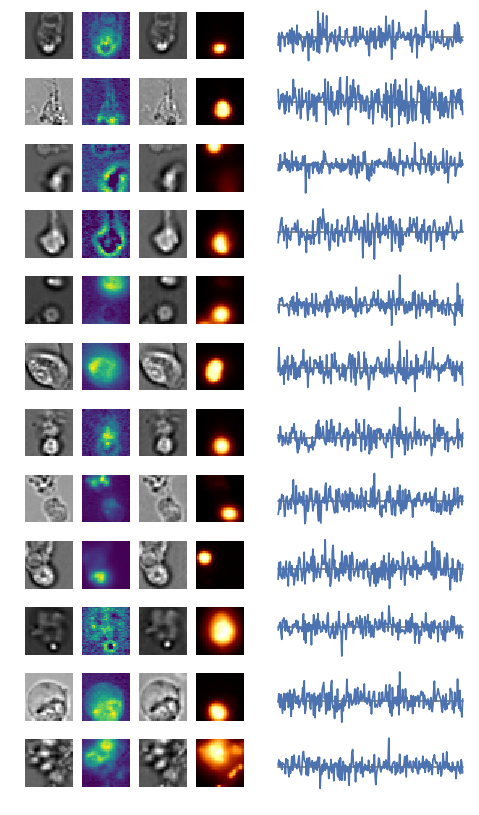

In [65]:
display_cluster(2, 12, outfile=None, c=clx)

In [47]:
from sklearn.manifold import TSNE

# geez = list()
# ceez = list()
# cindex = 0
# for i in (16,17, 18,19):
#     gna = g_all[agc == i]
#     ca = cindex #np.array(clist[cindex])
#     cna = np.repeat([i], gna.shape[0], axis=0)
#     geez.append(gna)
#     ceez.append(cna)
#     cindex += 1
# # c3 = gn3.shape[0]*(1, 0, 0)
# # c6 = gn3.shape[0]*(0, 1, 0)
# # c10 = gn3.shape[0]*(0, 0, 1)
# gn = np.concatenate(geez)
# cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
#print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=25).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)



(5701, 2)


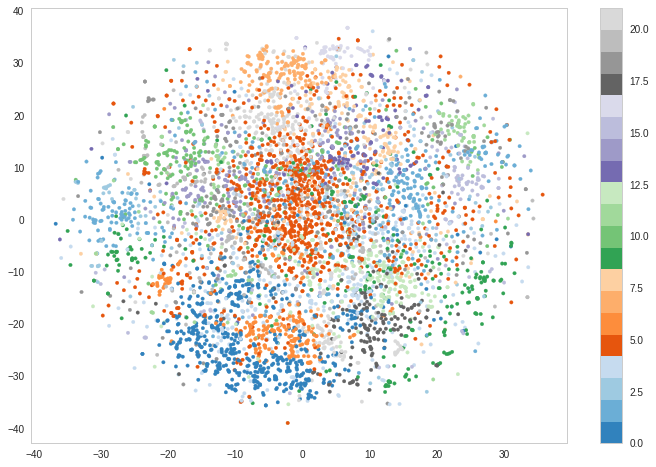

In [66]:
plt.figure(figsize=(12,8))
plt.subplot(1,1,1)
plt.scatter(g_emb[:,0], g_emb[:,1], 12, agc, cmap='tab20c')
plt.colorbar()

# plt.subplot(4,1,2)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, gm1, cmap='tab20c')
# plt.colorbar()

# plt.subplot(2,1,2)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, agc, cmap='tab20c')
# plt.colorbar()

# plt.subplot(4,1,4)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, km, cmap='tab20c')
# plt.colorbar()

<class 'numpy.ndarray'>


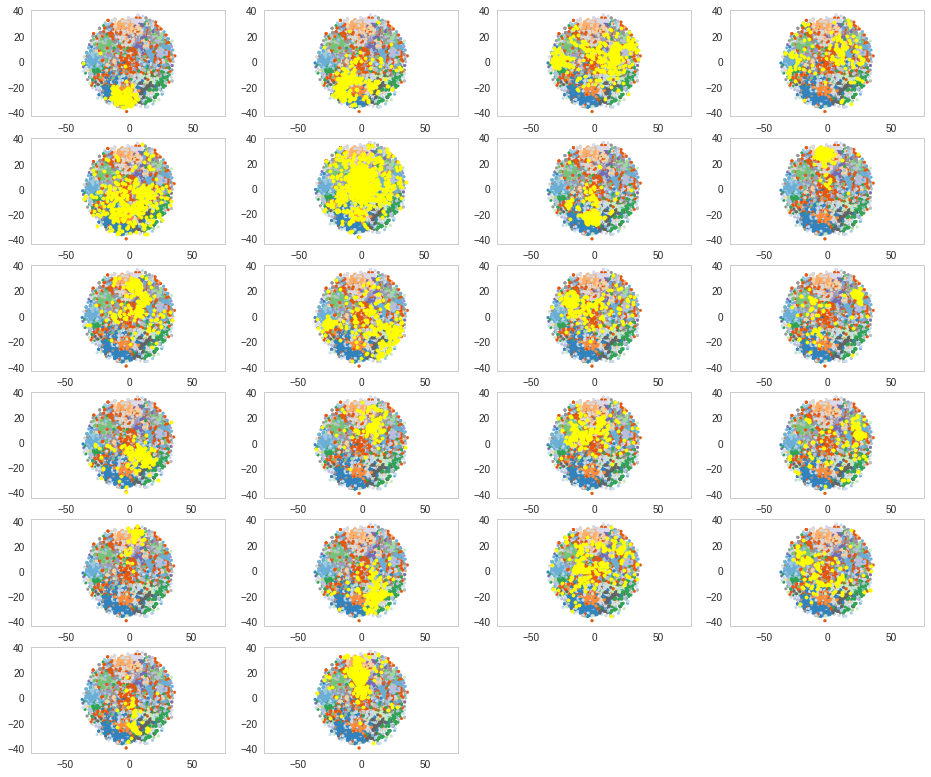

In [68]:

df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]
#df['gm'] = gm

#plt.ioff()
print(type(cly))
plt.figure(figsize=(16,16))
for index, i in enumerate(np.unique(cly)): #range(nclust):
#         plt.figure(figsize=(16,16))
        #ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color=gm, figsize=(6,6))
        #print(index, i)
        ax = plt.subplot(7,4, index + 1)
        ax.scatter(df['tsneX'], df['tsneY'], 8, agc, cmap='tab20c')
        xdf = df[df['agc'] == i]
        ax.scatter(xdf['tsneX'], xdf['tsneY'], label=i, s=12, color='yellow')
        ax.axis('equal')
        outfile = "/media/cjw/Data/cyto/TalkOutput/tsne_gm_" + str(i).zfill(3) + ".png"
        #break
        #plt.savefig(outfile, dpi=100, bbox_inches='tight', pad_inches=.1)
        #plt.clf()
        #plt.close()
#plt.ion()

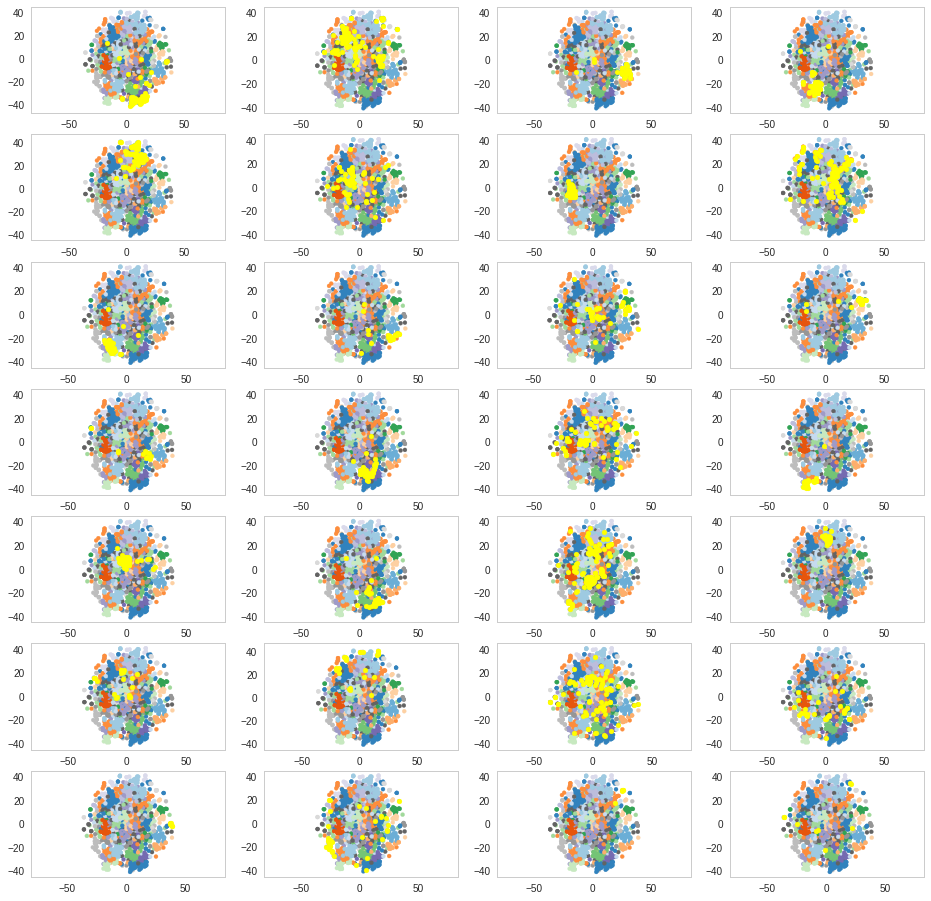

In [75]:
df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]
#df['gm'] = gm

#plt.ioff()

plt.figure(figsize=(16,16))
for i in range(nclust):
#         plt.figure(figsize=(16,16))
        #ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color=gm, figsize=(6,6))
        ax = plt.subplot(7,4, i + 1)
        ax.scatter(df['tsneX'], df['tsneY'], 16, agc, cmap='tab20c')
        xdf = df[df['agc'] == i]
        ax.scatter(xdf['tsneX'], xdf['tsneY'], label=i, s=24, color='yellow')
        ax.axis('equal')
        outfile = "/media/cjw/Data/cyto/TalkOutput/tsne_gm_" + str(i).zfill(3) + ".png"
        #break
        #plt.savefig(outfile, dpi=100, bbox_inches='tight', pad_inches=.1)
        #plt.clf()
        #plt.close()
#plt.ion()


In [92]:
for i in range(nclust):
    outfile = "/media/cjw/Data/cyto/TalkOutput/tsne_gm_cluster_" + str(i).zfill(3) + ".png"
    display_cluster(i, 10, outfile=outfile, c=gm, df=df)
    

In [75]:
df.head()

,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run,gm,agc,km,tsneX,tsneY
0,110085,0,5418,0,snail4_no_bact,110085,snail4_no_bact.mm,0,0,0,32,32,no_bact,snail4_,12,0,2,-0.713227,-31.618355
1,40186,0,2942,0,snail1_edta,40186,snail1_edta.mm,0,0,0,32,32,edta,snail1_,19,15,19,-15.114527,-17.825232
2,38712,0,1468,0,snail1_edta,38712,snail1_edta.mm,0,0,0,32,32,edta,snail1_,20,14,0,-16.682135,4.894446
3,182340,0,1934,0,snail2_no_bact,182340,snail2_no_bact.mm,0,0,0,32,32,no_bact,snail2_,16,4,15,12.338305,-1.801678
4,6234,0,6234,0,snail4_ice,6234,snail4_ice.mm,0,0,0,32,32,ice,snail4_,17,18,21,7.981800,17.804991


(22, 22) (22,) (22,)
[205. 269. 263. 388. 458. 239. 188. 212. 181. 209. 301. 190. 325. 169.
 203. 266. 207. 254. 389. 335. 264. 186.] (22,)
[2.35632184 3.84285714 2.55339806 1.84761905 2.36082474 2.43877551
 2.18604651 1.64341085 1.70754717 1.83333333 1.53571429 3.33333333
 1.91176471 1.92045455 2.23076923 2.3539823  2.4939759  2.67368421
 1.76818182 3.22115385 2.86956522 2.65714286] (22,)
[2.00609113 3.25022579 3.15797868 1.60624608 4.51754647 7.2088079
 1.94844614 1.32342492 2.49964322 3.15607814 2.3978648  1.2306219
 2.30345849 1.35517958 2.27004524 1.4219445  0.56473696 2.21242281
 2.53117872 1.97360165 1.25732581 1.54698754] (22,)
[2.28678776 2.70668397 2.25549492 3.17721665 3.16610816 3.09061704
 2.78540208 2.38048027 1.82046989 1.96037443 2.2717381  2.220197
 2.58362309 1.68163853 2.19937264 2.20675369 2.68976653 2.79221601
 2.95235862 3.99255344 3.29211663 2.1747433 ] (22,)
[1.6        2.96460177 2.08673469 3.5952381  5.27710843 4.5
 2.82417582 1.39534884 2.73684211 3.30232558 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5]),
 <a list of 22 Text yticklabel objects>)

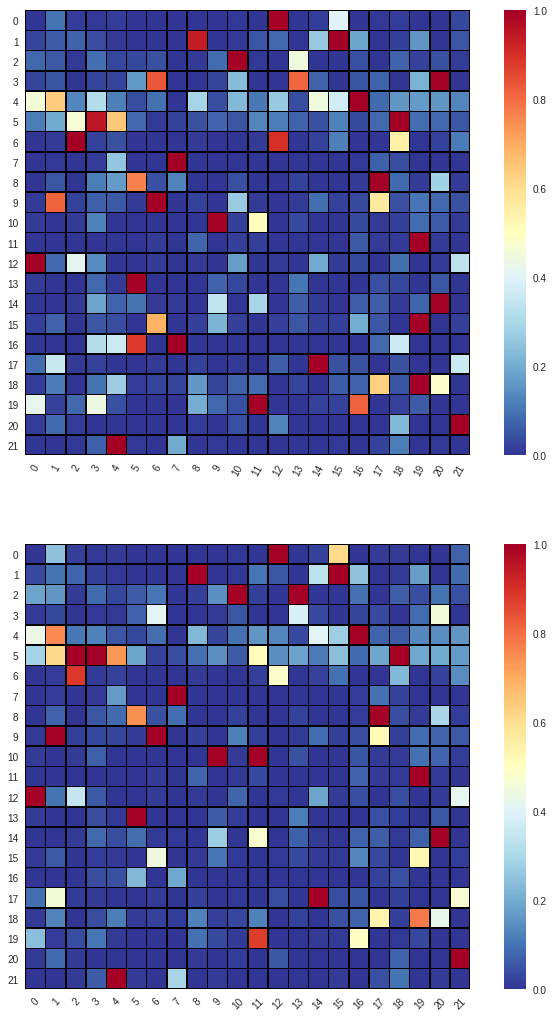

In [83]:
%matplotlib inline
from sklearn.preprocessing import normalize
p_df = pd.pivot_table(df, values='xc', index=['agc'], columns=['gm'], aggfunc='count')
p_df = p_df.fillna(0)
plt.figure(figsize=(12,18))
v = p_df.values
v0 = normalize(v, axis=0, norm='max')
print(v.shape, p_df.columns.shape, p_df.index.shape)
print(np.sum(v, axis=0), np.sum(v, axis=0).shape)
print(np.sum(v0, axis=0), np.sum(v0, axis=0).shape)
print(np.sum(v0, axis=1), np.sum(v0, axis=1).shape)
v1 = normalize(v, axis=1, norm='max')
print(np.sum(v1, axis=0), np.sum(v1, axis=0).shape)
print(np.sum(v1, axis=1), np.sum(v1, axis=1).shape)
plt.subplot(2,1,1)
sns.heatmap(v1, square=True, xticklabels=p_df.columns, yticklabels=p_df.index, cmap="RdYlBu_r",
           linewidth=.5, linecolor='black', robust=True)
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.subplot(2,1,2)
sns.heatmap(v0, square=True, xticklabels=p_df.columns, yticklabels=p_df.index, cmap="RdYlBu_r",
           linewidth=.5, linecolor='black', robust=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)


5701.0

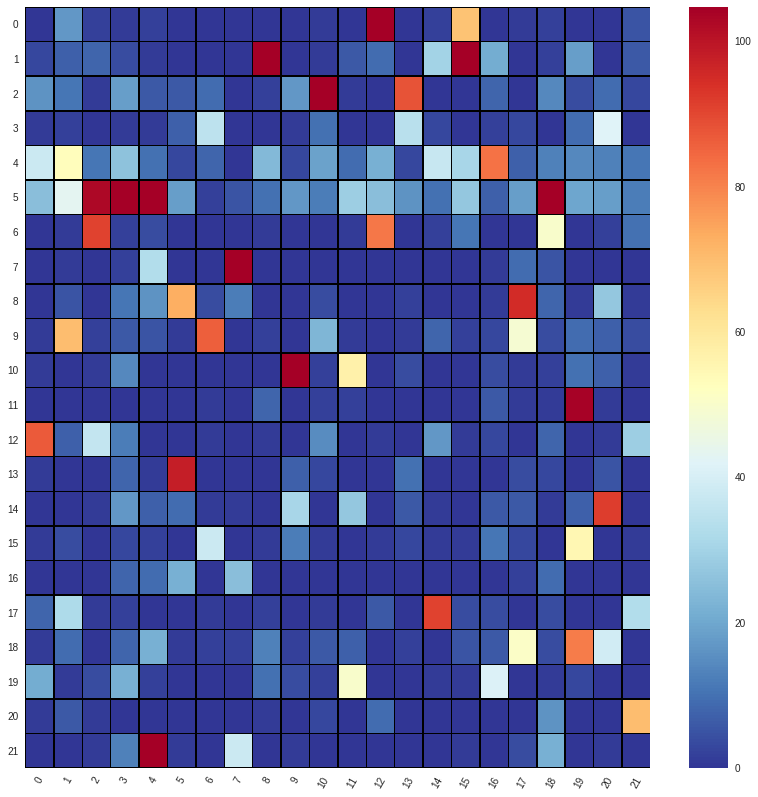

In [84]:
plt.figure(figsize=(14,14))

sns.heatmap(v, square=True, xticklabels=p_df.columns, yticklabels=p_df.index, cmap="RdYlBu_r",
           linewidth=.5, linecolor='black', robust=True)
plt.xticks(rotation=60)
plt.yticks(rotation=0)
np.sum(v)

Index(['snail1_no_bact', 'snail4_no_bact', 'snail2_no_bact', 'snail5_no_bact',
       'snail3_no_bact', 'snail1_edta', 'snail5_edta', 'snail2_edta',
       'snail3_edta', 'snail4_edta', 'snail5_ice', 'snail4_ice', 'snail3_ice',
       'snail2_ice', 'snail1_ice', 'snail2_phago', 'snail4_phago',
       'snail1_phago', 'snail3_phago', 'snail5_phago'],
      dtype='object', name='file')
(4, 22) (22,) (20,)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text yticklabel objects>)

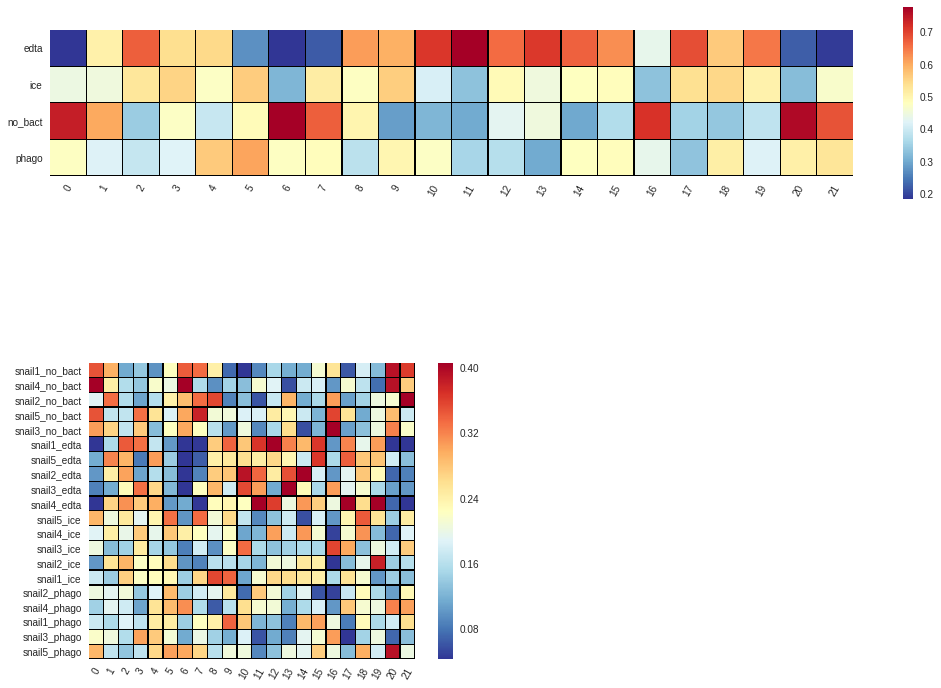

In [175]:
%matplotlib inline
from sklearn.preprocessing import normalize
p_df = pd.pivot_table(df, values='xc', index=['file'], columns=['agc'], aggfunc='count')
p_df2 = pd.pivot_table(df, values='xc', index=['treatment'], columns=['agc'], aggfunc='count')
p_df = p_df.fillna(0)
ind_pdf = p_df.index.to_series().str.split('_').str[-1].sort_values().index
print(ind_pdf)
p_df=p_df.reindex(index=ind_pdf)
plt.figure(figsize=(18,12))
v = p_df2.values
v0 = normalize(v, axis=0)
v1 = normalize(p_df.values, axis=0)
# print(np.sum(v, axis=0), np.sum(v, axis=0).shape)
# print(np.sum(v0, axis=0), np.sum(v0, axis=0).shape)
# print(np.sum(v0, axis=1), np.sum(v0, axis=1).shape)
# v1 = v #normalize(v, axis=1, norm='max')
# print(np.sum(v1, axis=0), np.sum(v1, axis=0).shape)
# print(np.sum(v1, axis=1), np.sum(v1, axis=1).shape)
print(v.shape, p_df.columns.shape, p_df.index.shape)

plt.subplot(3,1,1)
sns.heatmap(v0, square=True, cmap="RdYlBu_r", yticklabels=list(p_df2.index), xticklabels=list(p_df2.columns),
            linewidth=.25, linecolor='black', robust=True)
plt.xticks(rotation=60)
plt.yticks(rotation=0)

plt.subplot(2,2,3)
sns.heatmap(v1, square=True, cmap="RdYlBu_r", yticklabels=list(p_df.index), xticklabels=list(p_df.columns),
            linewidth=.25, linecolor='black', robust=True)
plt.xticks(rotation=60)
plt.yticks(rotation=0)


In [214]:
agco.children_[len(df) - 2]

array([11398, 11399])

In [215]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

In [216]:
agco.n_components_, agco.n_leaves_

(1, 5701)

In [222]:
agco.children_[0:2]

array([[1964, 3217],
       [5386, 5701]])

In [221]:
agco.children_ == len(df)

array([[False, False],
       [False,  True],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [223]:
from scipy.cluster.hierarchy import dendrogram

In [312]:
def ccf(id):
    if id < nclust:
        return(str(id))
    else:
        str(agc[id])

def plot_dendrogram(model, labels=None):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    print(no_of_observations.shape)
    print(linkage_matrix.shape)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, nclust, truncate_mode='lastp', orientation='right')#, leaf_label_func=ccf)
    plt.xlim(5670,len(df))

(5700,)
(5700, 4)


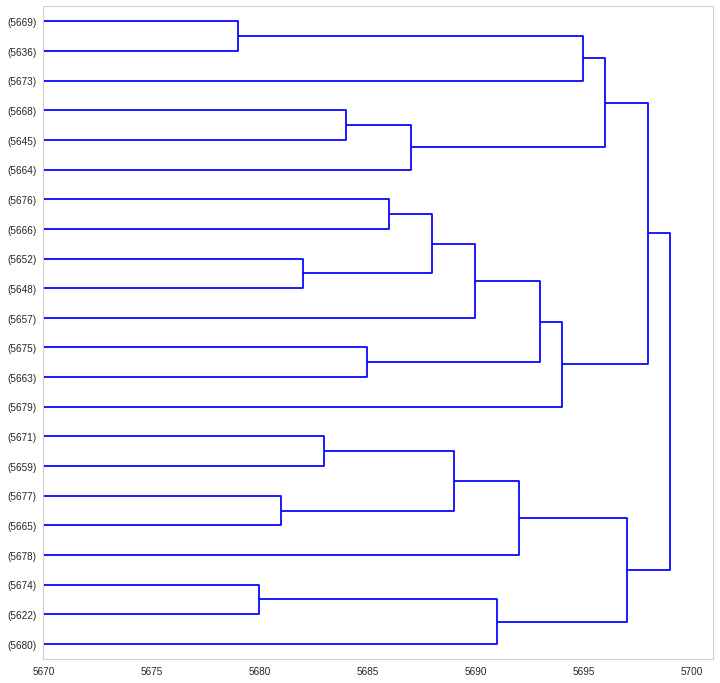

In [313]:
plt.figure(figsize=(12,12))
plot_dendrogram(agco, labels=agc)


In [289]:
agco.children_[0], agc[1964], agc[3217]
kids  = agco.children_

In [297]:
kids[kids[:,0] == 5702]


array([], shape=(0, 2), dtype=int64)

array([10882, 10998])